<a href="https://colab.research.google.com/github/zakaryael/american_option_pricing/blob/master/American_Option_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D


class Market(object):
    def __init__(self, rate, volatility, T):
        self.rate = rate
        self.volatility = volatility
        self.T = T


class Asset(object):
    """risky asset"""
    def __init__(self, market, initialPrice, m = 1):
        self.market = market
        self.initialPrice = initialPrice
        self.m = m #time steps
    
    def simulate(self, n):
        """simulates n independent trajectories of an asset following the Black Scholes model"""
        """ each line is an independent trajectory"""
        m = self.m
        T = self.market.T
        tt = np.linspace(0, T, m + 1)
        S = np.zeros((n, m + 1))
        for i in range(n):
            z = np.random.normal(0, np.sqrt(1 / (m)), m + 1)
            z[0] = 0
            w = np.cumsum(z)
            S[i] = self.initialPrice * np.exp((self.market.rate - self.market.volatility ** 2 / 2) * tt + self.market.volatility * w)
        if (m == 1):
            return S[:, -1]
        else:
            return tt, S
    
    def trajectory(self):
        """plots a trajectory of the asset price"""
        traj = self.simulate(1)
        xaxis = traj[0]
        yaxis = traj[1][0]
        plt.plot(xaxis, yaxis, 'maroon')
        plt.show()


class Option(object):
    def __init__(self, asset, strike, is_put = True, is_american = True):
        self.market = market
        self.asset = asset
        self.strike = strike
        self.is_put = is_put
        self.is_american = is_american
        self.m = asset.m
    
    def payoff(self, x):
        if self.is_put:
            return np.maximum(0, self.strike - x)
        else:
            return np.maximum(0, x - self.strike)

class MCeu(Option):
    def __sim__(self, n):
        x = self.asset.simulate(n)
        self.sim = self.payoff(x) * np.exp(-self.asset.market.rate * self.asset.market.T)

    def estim_price(self, n, level = 0.95):
        self.__sim__(n)
        self.level = level
        delta = np.mean(self.sim)
        Var = np.var(self.sim)
        CI = [delta + q * np.sqrt(Var/n) for q in norm.interval(level)]
        return {"option price":delta, "confidence interval":CI, "variance":Var}
    
    def evolution(self):
        "must price first"
        y = self.sim
        n = len(y)
        nvec = np.arange(1, n+1)
        print(len(np.cumsum(y)))
        delta = np.cumsum(y) / nvec
        Var = np.zeros(n)
        Var[1:] =  (np.cumsum(y**2)[1:] - nvec[1:] * (delta[1:] ** 2)) / nvec[:n-1]; Var[0] = 0
        q = norm.interval(self.level)[1]
        i1 = delta - q * np.sqrt (Var / nvec)
        i2 = delta + q * np.sqrt (Var / nvec)
        return delta, i1, i2

class CRR(Option):
    def price_tree(self, N):
        """computes the matrix of prices in the CRR model of N periods"""
        self.u = np.exp(self.asset.market.volatility * np.sqrt(self.asset.market.T / N))
        self.d = 1 / self.u
        self.p = (np.exp(self.asset.market.rate * self.asset.market.T / N) - self.d) / (self.u - self.d)
        S = np.zeros((N + 1, N + 1))
        S0 = self.asset.initialPrice
        for j in range(N + 1):
            for i in range(j + 1):
                S[i][j] = S0 * self.u**(j - i) * self.d**i
        return S
       
    def option_tree(self, N):
        """computes the price of an option in the CRR model of N periods"""
        S = self.price_tree(N)
        C =  np.zeros((N + 1, N + 1))
        C[:, N] = self.payoff(S[:, N])
        x = np.zeros(N + 1)
        for j in range(N - 1, -1, -1):
            x[0 : N] = C[1 :, j + 1]     
            C[:, j] = np.exp(- self.asset.market.rate * self.asset.market.T / N) * (self.p * C[:, j + 1] + (1 - self.p) * x)
            if self.is_american:
                C[:, j] = np.maximum(C[:, j], self.payoff(S[:, j]))
        return C

    def price(self, N):
        return self.option_tree(N)[0][0]


class Finite_Diff(Option):
    def __init__(self, asset, strike, Smin, Smax, n, N, theta, is_put = True):
        self.asset = asset
        self.strike = strike
        self.Smin = Smin
        self.Smax = Smax
        self.Xmin = np.log(Smin)
        self.Xmax = np.log(Smax)
        self.theta = theta
        self.n, self.N = int(n), int(N) # Ensure m & n are integers
        self.dX = (self.Xmax - self.Xmin) / float(N)
        self.dt = asset.market.T / float(n)
        self.grid = np.zeros(shape=(N + 1, n + 1))
        self.space_values = np.exp(np.linspace(self.Xmin, self.Xmax, N + 1))
        self.time_values = np.linspace(0, self.asset.market.T, n + 1)
        self.is_put = is_put
        self.theta = theta

    def _setup_coefficients_(self):
        pass

    def _setup_boundary_conditions_(self):
        pass

    def _initial_conditions_(self, u = None):
        pass

    def _traverse_grid_(self):
           """  Iterate the grid backwards in time """
           pass

    def _interpolate_(self):
           """ Use piecewise linear interpolation on the initial grid column to get the closest price at S0. """
           return np.interp(self.asset.initialPrice, self.space_values, self.grid[:, -1])
    def plot3d(self):
      Y = self.space_values
      X = optionFDeu.time_values[::-1]
      X, Y = np.meshgrid(X, Y)
      Z = optionFDeu.grid
      fig = plt.figure()
      ax = fig.gca(projection='3d')
      surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap = 'seismic',linewidth=0, antialiased=False)
      fig.colorbar(surf, shrink=0.5, aspect=5)
      plt.show()

    def price(self):
        self._setup_coefficients_()
        self._setup_boundary_conditions_()
        self._initial_conditions_()
        self._traverse_grid_()
        return self._interpolate_()


class FDeu(Finite_Diff):
    def _setup_coefficients_(self):
        self.alpha = self.asset.market.volatility**2 / (2 * self.dX**2) - (1 / (2 * self.dX)) * (self.asset.market.rate - (self.asset.market.volatility**2 / 2))
        self.beta = - (self.asset.market.volatility**2 / self.dX**2) - self.asset.market.rate
        self.gamma = self.asset.market.volatility**2 /( 2 * self.dX**2) + (1 / (2 * self.dX)) * (self.asset.market.rate - (self.asset.market.volatility**2 / 2))
        self.A = np.diag([self.beta] * (self.N + 1)) + np.diag([self.alpha] * self.N, -1)+ np.diag([self.gamma] * self.N, 1)
        self.R = np.identity(self.N + 1) - self.theta * self.dt * self.A
        self.G = np.identity(self.N + 1) + (1 - self.theta) * self.dt * self.A
        self.R = np.linalg.inv( np.identity(self.N + 1) - self.theta * self.dt * self.A)

    def _invert_matrix_(self, M, v):
        a = np.zeros((self.N + 1, 2))
        a[-1][0], a[-1][1] = np.diag(M)[-1], v[-1]
        for i in range(self.N - 1, -1, -1):
            a[i][0] = np.diag(M)[i] - np.diag(M, 1)[i] * np.diag(M, -1)[i] / a[i + 1][0]
            a[i][1] = v[i] - np.diag(M, 1)[i] * a[i + 1][1] / a[i + 1][0]
        v[0] = a[0][1] / a[0][0]
        for i in range(1, self.N + 1):
            v[i] = (a[i][1] - np.diag(M, -1)[i - 1] * v[i - 1]) / a[i][0]
        return v

    def _setup_boundary_conditions_(self):
        self.F = np.zeros(self.N + 1)
        self.F[0] = self.alpha * np.exp(- self.asset.market.rate * self.asset.market.T) * self.payoff(np.exp(self.asset.market.rate * self.asset.market.T + self.Xmin))
        self.F[-1] =  self.gamma * np.exp(- self.asset.market.rate * self.asset.market.T) * self.payoff(np.exp(self.asset.market.rate * self.asset.market.T + self.Xmax))

    def _initial_conditions_(self, u = None):
        if u is None:
            self.grid[:, 0] = self.payoff(self.space_values)
        else:   self.grid[:, 0] = u

    def _traverse_grid_(self):
        for i in range(self.n):
            #self.grid[:, i + 1] = self._invert_matrix_(self.R, self.dt * self.F + self.G.dot(self.grid[:, i]))
            self.grid[:, i + 1] = self.R.dot(np.identity(self.N + 1) + (1 - self.theta) * self.dt * self.A).dot(self.grid[:, i]) + self.R.dot(self.dt * self.F)

    def curve(self):
        self.price()
        plt.xlabel('Price S0')
        if self.is_put:
            plt.ylabel('Price of a european put option at time t=0')
        else:
            plt.ylabel('Price of a european call option at time t=0')
        plt.plot(self.space_values, self.grid[:, -1],'maroon')
        plt.show()

    def price_vec(self, u):
        self._setup_coefficients_()
        self._setup_boundary_conditions_()
        self._initial_conditions_(u)
        self._traverse_grid_()
        return self.grid[:, -1]

class FDam(FDeu):
    "finite differences for an american option"
    def _traverse_grid_(self):
        self.grid = np.zeros(shape=(self.N + 1, self.asset.m + 1))
        self.grid[:, 0] = self.payoff(self.space_values)
        for i in range(self.asset.m):
            market = Market(self.asset.market.rate, self.asset.market.volatility, self.asset.market.T / self.asset.m)
            asset = Asset(market, self.asset.initialPrice)
            option = FDeu(asset, self.strike, self.Smin, self.Smax, self.n, self.N, self.theta, self.is_put)
            self.grid[:, i + 1] = np.maximum(self.payoff(self.space_values), option.price_vec(self.grid[:, i]))

    def price(self):
        self._traverse_grid_()
        return self._interpolate_()


class TVR(MCeu):
    """pricing an american option using the Tsitsikliss Van Roy method"""
    def __init__(self, asset, strike, n, is_put=True, with_payoff=True):
        self.market = market
        self.asset = asset
        self.strike = strike
        self.is_put = is_put
        self.m = asset.m
        self.n = n
        self.with_payoff = with_payoff
        self.model = []

    def features(self, x):
        return np.column_stack((x, x ** 2, self.with_payoff * self.payoff(x)))

    def projection(self, model, x): 
        return model.predict(self.features(x))

    def regression(self, x, y):
        X = self.features(x)
        model = linear_model.LinearRegression()
        model.fit(X, y)
        return model.predict(X), model


    def recursion(self, S):
        self.V = np.zeros((self.n, self.asset.m + 1))
        self.V[:, -1] = self.payoff(S[:, -1])
        for i in range(self.asset.m - 1, -1, -1):
            self.V[:, i] = np.maximum(self.payoff(S[:, i]), np.exp(- self.asset.market.rate / (self.asset.market.T * self.asset.m)) * self.regression(S[:, i], self.V[: ,i + 1])[0])

    def price(self):       
        S = self.asset.simulate(self.n)[1]
        self.recursion(S)
        return np.mean(self.V[:, 0])
    

class LongShwartz(TVR):
    """docstring for LongShwartz."""
    def recursion(self, S):
        self.V = np.zeros((self.n, self.asset.m + 1))
        self.V[:, -1] = self.payoff(S[:, -1])
        self.model = []
        for i in range(self.asset.m - 1, -1, -1):
            Y = self.regression(S[:, i], self.V[: ,i + 1])
            self.model.append(Y[1])
            self.V[:, i] = (self.payoff(S[:, i]) >= np.exp(- self.asset.market.rate / (self.asset.market.T * self.asset.m)) * Y[0]) * (self.payoff(S[:, i]) - self.V[:, i + 1]) + self.V[:, i + 1]

    def tau(self, x):
        tt, S = self.asset.simulate(self.n)
        self.recursion(S)
        m = len(tt) - 1
        n = len(x)
        tau = np.zeros((n, m + 1))
        tau[:, -1] = np.ones(n) * tt[-1]
        for i in range(m - 1, -1, -1):
            tau[:, i] = (self.payoff(x[:, i]) >= np.exp(- self.asset.market.rate / (self.asset.market.T * m)) * self.projection(self.model[m - i - 1], x[:, i])) * (tt[i] - tau[:, i + 1]) + tau[:, i + 1]
        return tau
    
    def __sim__(self, n):
        S = self.asset.simulate(n)[1]
        tau1 = self.tau(S)[:, 0]
        y = np.zeros(n)
        for k in range(n):
          i = int(tau1[k] * self.asset.m / self.asset.market.T)
          y[k] = self.payoff(S[k][i])
        self.sim = y 


def bs_price(rate, volatility, T, strike, S0, is_put): 
    '''the exact price of a european option using Black & Scholes formula'''
    d = (1 / (volatility * np.sqrt(T))) * (np.log(S0 / strike) + (rate + 0.5 * volatility**2) * T)
    if is_put: return strike * np.exp(- rate * T) * norm.cdf(- d + volatility * np.sqrt(T)) - S0 * norm.cdf(- d)  
    else: return S0 * norm.cdf(d) - strike * np.exp(- rate * T) * norm.cdf(d - volatility * np.sqrt(T))




Introduction des paramètres :

In [0]:
rate = 0.1
volatility = 0.2
T = 1
S0 = 100
strike = 100

market = Market(rate, volatility, T)

Estimation du prix d'une option européenne par la méthode de Monte-Carlo : 



In [0]:
n = 100000
is_put = True  # Nature de l'option

assetMC = Asset(market, S0)
optionMCeu = MCeu(assetMC, strike, is_put)
optionMCeu.estim_price(n)

{'confidence interval': [3.6925139986309934, 3.7789481051286997],
 'option price': 3.7357310518798466,
 'variance': 48.619906621222505}

Évolution et convergence de l'estimation du prix d'un call européen 
par la méthode de Monte-Carlo en fonction du nombre de simulations :


100000
3.75341838825684


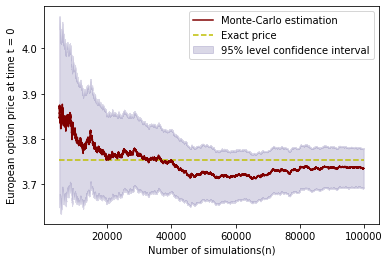

In [0]:

evol = optionMCeu.evolution()   # Remarque : Pour générer une nouvelle évolution, il faut d'abord réexécuter la case d'avant !
exactPrice = bs_price(rate, volatility, T, strike, S0, is_put)
print(exactPrice)
naxis = np.arange(int(0.05 * n), n)
estimation = evol[0][int(0.05 * n):]
lowerBound = evol[1][int(0.05 * n):]
upperBound = evol[2][int(0.05 * n):]
plt.hlines(exactPrice, naxis[0], naxis[-1], label = "Exact price", linestyles = 'dashed', color = 'y')
plt.xlabel('Number of simulations(n)')
plt.ylabel('European option price at time t = 0')
plt.plot(naxis, estimation, 'maroon', label='Monte-Carlo estimation')
plt.fill_between(naxis,lowerBound,upperBound,alpha=.2, label = '95% level confidence interval', color='darkslateblue'), #label = '95% level confidence interval' 
plt.legend()
plt.show()

Estimation du prix d'une option européenne par la méthode de CRR :


In [0]:
N = 100
is_put = True 

assetCRR = Asset(market, S0) 
optionCRReu = CRR(assetCRR, strike, is_put, is_american=False)
optionCRReu.price(N)

3.7325626001865007

Estimation du prix d'une option américaine par la méthode de CRR :


In [0]:
optionCRRam = CRR(assetCRR, strike, is_put, is_american=True)
optionCRRam.price(N)

4.808610311562313

Évolution et convergence de l'estimation du prix par la méthode CRR en fonction du nombre de simulations :



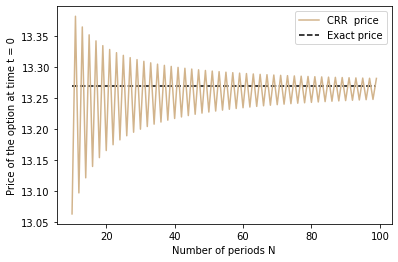

13.269676584660893

In [0]:
N = 100
is_put = False
is_american = False

Naxis = np.arange(int(0.1 * N), N)
exactprice = bs_price(rate, volatility, T, strike, S0, is_put)
plt.xlabel('Number of periods N')
plt.ylabel('Price of the option at time t = 0')
plt.plot(Naxis, [CRR(assetCRR, strike, is_put, is_american).price(i) for i in range(int(0.1 * N), N)], 'tan', label = 'CRR  price')
if is_american:
  pass            
else : 
  plt.hlines(exactprice, Naxis[0], Naxis[-1], label = "Exact price", linestyles = 'dashed', color = 'black')
  plt.legend()
plt.show()
exactprice

Comparaison du prix d'un put américaine et européenne à l'instant t = 0, obtenu par la méthode CRR et en fonction de S0 :


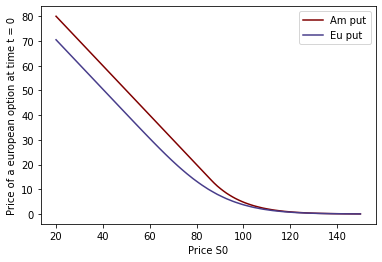

In [0]:
N = 100      
S = np.linspace(20, 150, N + 1)
amput = [CRR(Asset(Market(rate, volatility, T), S[i]), strike, is_put=True, is_american=True).price(N) for i in range(N +1)]
euput = [CRR(Asset(Market(rate, volatility, T), S[i]), strike, is_put=True, is_american=False).price(N) for i in range(N +1)] 
plt.xlabel('Price S0')
plt.ylabel('Price of a european option at time t = 0')      
plt.plot(S, amput, 'maroon', label='Am put')
plt.plot(S, euput, 'darkslateblue', label='Eu put')
plt.legend()
plt.show()

Estimation du prix d'une option européenne par la méthode des Différences Finies :

In [0]:
n = 1000
N = 100
Smin = 20
Smax = 200
theta = 1
is_put = False

assetFD = Asset(market, S0)
optionFDeu = FDeu(assetFD, strike, Smin, Smax, n, N, theta, is_put)
optionFDeu.price()


13.27043996175137

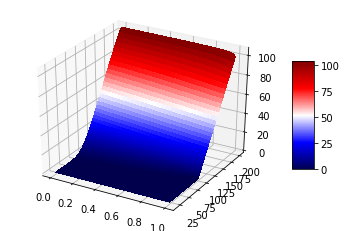

In [0]:
optionFDeu.plot3d()

Estimation du prix d'une option américaine par la méthode des Différences Finies :

In [0]:
m = 20
assetFDam = Asset(market, S0, m)
optionFDam = FDam(assetFDam, strike, Smin, Smax, n, N, theta, is_put)
optionFDam.price()

13.261813027865863

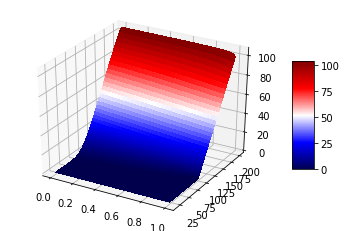

In [0]:
optionFDam.plot3d()

Comparaison du prix d'un put américain et européen à l'instant t = 0, obtenu par la méthode des D-F et en fonction de S0 :

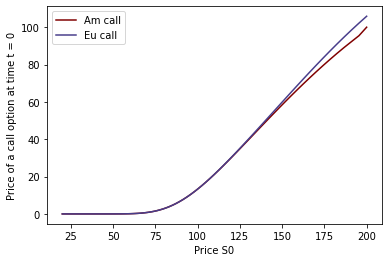

In [0]:
X = optionFDeu.space_values      
Y = optionFDeu.grid[:, -1]
Z = optionFDam.grid[:, -1]
plt.xlabel('Price S0')

if optionFDeu.is_put:
    plt.ylabel('Price of a put option at time t = 0')
    plt.plot(X, Z, 'maroon', label='Am put')
    plt.plot(X, Y, 'darkslateblue', label='Eu put')
else :
    plt.ylabel('Price of a call option at time t = 0')
    plt.plot(X, Z, 'maroon', label='Am call')
    plt.plot(X, Y, 'darkslateblue', label='Eu call')
plt.legend()
plt.show()

Estimation du prix d'un put américain par la méthode de Tsitsikliss & Van Roy :

In [0]:
m = 100
n = 100000
is_put = False

assetTVR = Asset(market, S0, m)
optionTVR = TVR(assetTVR, strike, n, is_put, with_payoff=True)
optionTVR.price()

13.546685604783137

sans prendre la fonction payoff dans la base:

In [0]:
optionTVR = TVR(assetTVR, strike, n, is_put, with_payoff=False)
optionTVR.price()

15.426836077545406

Estimation du prix d'un put américain par la méthode de Longstaff & Schwartz :

In [0]:
m = 100
n_tilde = 100000
n = 100
is_put = False

assetLS = Asset(market, S0, m)
optionLS = LongShwartz(assetLS, strike, m, is_put, with_payoff=False)
optionLS.n = n
optionLS.estim_price(n_tilde)

{'confidence interval': [12.980516455596455, 13.155191442423362],
 'option price': 13.067853949009908,
 'variance': 198.5661726907919}

In [0]:
optionLS = LongShwartz(assetLS, strike, m, is_put, with_payoff=True)
optionLS.estim_price(n_tilde)

{'confidence interval': [12.740527647808587, 12.952502925815079],
 'option price': 12.846515286811833,
 'variance': 292.4248350904546}

Évolution de l'estimation par la méthode de Longstaff & Schwartz en fonction du nombre de simulations :

100000


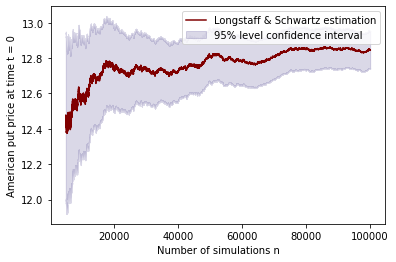

In [0]:
n = n_tilde
evol = optionLS.evolution()  # Remarque : Pour générer une nouvelle évolution, il faut d'abord réexécuter la case d'avant
naxis = np.arange(int(0.05 * n), n)   
estimation = evol[0][int(0.05 * n):]
lowerBound = evol[1][int(0.05 * n):]
upperBound = evol[2][int(0.05 * n):]
plt.xlabel('Number of simulations n')
plt.ylabel('American put price at time t = 0')
plt.plot(naxis, estimation, 'maroon', label='Longstaff & Schwartz estimation')
plt.fill_between(naxis,lowerBound,upperBound,alpha=.2, label = '95% level confidence interval', color='darkslateblue')
plt.legend()
plt.show()

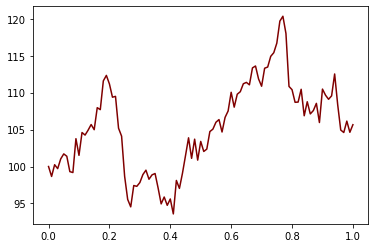

In [0]:
assetLS.trajectory()